In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
df = pd.read_excel("../../raw_data/market_data.xlsx").reset_index(drop = True)
df["Time (UTC+10)"] = pd.to_datetime(df["Time (UTC+10)"])
vicp = df["Regions VIC Trading Price ($/MWh)"]
vicd = df["Regions VIC Operational Demand (MW)"]
time = df["Time (UTC+10)"]

In [51]:
price = pd.DataFrame()
price["time"] = time
price["price"] = vicp

demand = pd.DataFrame()
demand["time"] = time
demand["demand"] = vicd

In [52]:
price

,time,price
0,2018-01-01 00:00:00,90.43
1,2018-01-01 00:30:00,92.46
2,2018-01-01 01:00:00,87.62
3,2018-01-01 01:30:00,73.08
4,2018-01-01 02:00:00,70.18
...,...,...
63452,2021-08-14 22:00:00,49.93
63453,2021-08-14 22:30:00,62.86
63454,2021-08-14 23:00:00,32.26
63455,2021-08-14 23:30:00,25.10


In [53]:
vicp

0        90.43
1        92.46
2        87.62
3        73.08
4        70.18
         ...  
63452    49.93
63453    62.86
63454    32.26
63455    25.10
63456     8.73
Name: Regions VIC Trading Price ($/MWh), Length: 63457, dtype: float64

In [54]:
def CMA(df, col, n):
    MA = []
    dfc = df.reset_index(drop = True)
    print(dfc)
    for i in dfc.index:
        if (i > n - 1) and i < len(df) - n:
            Period = []
            for j in range(1, n + 1):
                Period.append(df[col].loc[i - j])
                Period.append(df[col].loc[i + j])
            entry = np.mean(Period)
        else:
            entry = np.nan

        MA.append(entry)
        
    dfn = pd.DataFrame()
    dfn["MA"] = MA
    
    dff = pd.merge(dfc, dfn, left_index = True, right_index = True, how = "inner")
    return dff.dropna().reset_index(drop = True)

In [55]:
PriceMA = CMA(price, "price", 5)
PriceMA.columns = ["Time", "Price", "MA"]

                     time  price
0     2018-01-01 00:00:00  90.43
1     2018-01-01 00:30:00  92.46
2     2018-01-01 01:00:00  87.62
3     2018-01-01 01:30:00  73.08
4     2018-01-01 02:00:00  70.18
...                   ...    ...
63452 2021-08-14 22:00:00  49.93
63453 2021-08-14 22:30:00  62.86
63454 2021-08-14 23:00:00  32.26
63455 2021-08-14 23:30:00  25.10
63456 2021-08-15 00:00:00   8.73

[63457 rows x 2 columns]


<AxesSubplot:ylabel='Price'>

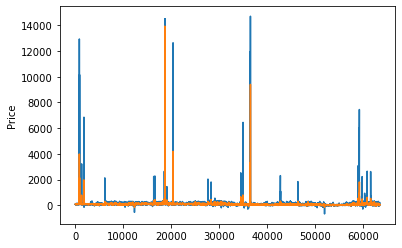

In [56]:
sns.lineplot(y = PriceMA["Price"], x = PriceMA.index)
sns.lineplot(y = PriceMA["MA"], x = PriceMA.index)

In [57]:
UpperPrice = PriceMA[PriceMA.Price >= PriceMA.MA]
LowerPrice = PriceMA[PriceMA.Price < PriceMA.MA]

In [58]:
DemandMA = CMA(demand, "demand", 5)
DemandMA.columns = ["Time", "Demand", "MA"]

                     time  demand
0     2018-01-01 00:00:00    4599
1     2018-01-01 00:30:00    4398
2     2018-01-01 01:00:00    4238
3     2018-01-01 01:30:00    4112
4     2018-01-01 02:00:00    3956
...                   ...     ...
63452 2021-08-14 22:00:00    5492
63453 2021-08-14 22:30:00    5344
63454 2021-08-14 23:00:00    5204
63455 2021-08-14 23:30:00    5268
63456 2021-08-15 00:00:00    5244

[63457 rows x 2 columns]


<AxesSubplot:ylabel='Demand'>

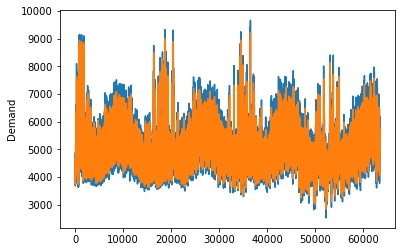

In [59]:
sns.lineplot(y = DemandMA["Demand"], x = DemandMA.index)
sns.lineplot(y = DemandMA["MA"], x = DemandMA.index)

In [60]:
UpperDemand = DemandMA[DemandMA.Demand >= DemandMA.MA]
LowerDemand = DemandMA[DemandMA.Demand < DemandMA.MA]

In [61]:
def intersect(price, demand, status):
    inter = pd.merge(price, demand, on = "Time", how = "inner")
    inter["Status"] = status
    return inter.drop(["MA_x", "MA_y"], axis = 1)

In [62]:
Charge = intersect(LowerPrice, LowerDemand, "Charge")
Discharge = intersect(UpperPrice, UpperDemand, "Discharge")

In [63]:
def BiggerPicture(df, Charge, Discharge):
    cdc = pd.concat([Charge, Discharge], ignore_index = True)

    cdc = cdc[["Time", "Status"]]
    dff = pd.merge(df, cdc, left_on = "Time (UTC+10)", right_on = "Time", how = "left")
    
    return dff[["Time (UTC+10)", "Status"]].replace(np.nan, "Do Nothing")

In [64]:
df = BiggerPicture(df, Charge, Discharge)

In [65]:
dff = pd.merge(df, price, left_on = "Time (UTC+10)", right_on = "time", how = "left").drop('time', axis = 1)
dff

,Time (UTC+10),Status,price
0,2018-01-01 00:00:00,Do Nothing,90.43
1,2018-01-01 00:30:00,Do Nothing,92.46
2,2018-01-01 01:00:00,Do Nothing,87.62
3,2018-01-01 01:30:00,Do Nothing,73.08
4,2018-01-01 02:00:00,Do Nothing,70.18
...,...,...,...
63452,2021-08-14 22:00:00,Do Nothing,49.93
63453,2021-08-14 22:30:00,Do Nothing,62.86
63454,2021-08-14 23:00:00,Do Nothing,32.26
63455,2021-08-14 23:30:00,Do Nothing,25.10


In [66]:
BATTERY_CAPACITY = 580 # maximum capacity MWH
DISCHARGE_EFFICIENCY = 100/90
DISCHARGE_EFFICIENCY_2 = 0.9
CHARGE_EFFICIENCY = 0.9

# steps to calculate revenue

raw_power = 0
opening_capacity = 0
closing_capacity = 0
market_dispatch = 0

raw_power_s = pd.Series(dtype = float)
opening_capacity_s = pd.Series(dtype = float)
closing_capacity_s = pd.Series(dtype = float)
market_dispatch_s = pd.Series(dtype = float)

# current_capacity_s.loc[0] = 1
# calculate market revenue -> need market dispatch
# create market dispatch

status = dff['Status']

#change formula to , added revised formula
#try on other algorithms

for i in dff.index:
    #print(status[i])
    if i == 0:
        opening_capacity_s.loc[i] = 0
    else:
        opening_capacity = closing_capacity_s.loc[i-1]
        # print(opening_capacity)
        opening_capacity_s.loc[i] = closing_capacity_s.loc[i-1]
    if status[i] == 'Charge':
        raw_power = -min(300, (int(BATTERY_CAPACITY) - float(opening_capacity_s[i])) * 2) # 300 is the minimum capacity
        market_dispatch = raw_power/2
        closing_capacity = max(0, min(opening_capacity_s[i] - market_dispatch * CHARGE_EFFICIENCY, BATTERY_CAPACITY))
        #print(min(opening_capacity_s[i] - market_dispatch * CHARGE_EFFICIENCY, BATTERY_CAPACITY))
        raw_power_s.loc[i] = raw_power
        market_dispatch_s.loc[i] = market_dispatch
        closing_capacity_s.loc[i] = closing_capacity
        #print(raw_power, market_dispatch, opening_capacity, closing_capacity, i)
        #print(current_capacity)
    elif status[i] == 'Discharge':
        #print(i, "inside")
        raw_power = min(300, float(opening_capacity_s[i]) * 2)
        #print(raw_power, print(opening_capacity_s[i]))
        market_dispatch = raw_power/2 * DISCHARGE_EFFICIENCY_2
        closing_capacity = max(0, min(opening_capacity_s[i] - (market_dispatch * DISCHARGE_EFFICIENCY), BATTERY_CAPACITY))
        #print(i, closing_capacity, opening_capacity)
        market_dispatch_s.loc[i] = market_dispatch
        closing_capacity_s.loc[i] = closing_capacity
        raw_power_s.loc[i] = raw_power
        #print(current_capacity)
    else:
        raw_power_s.loc[i] = 0
        market_dispatch_s.loc[i] = 0
        closing_capacity_s.loc[i] = closing_capacity
    
    #print('opening:', i, opening_capacity_s.loc[i])
    #print('closing:', i, closing_capacity_s.loc[i])
    
#print('opening capacity: \n', opening_capacity_s)
#print('closing capacity: \n', closing_capacity_s)
#print('raw power: \n', raw_power_s)
#print('market dispatch: \n', market_dispatch_s)


In [67]:
dff['raw power'] = raw_power_s
dff['market dispatch'] = market_dispatch_s
dff['opening capacity'] = opening_capacity_s
dff['closing capacity'] = closing_capacity_s

In [68]:
MARGINAL_LOSS_FACTOR = 0.991

revenue_s = pd.Series(dtype = float)
for i in dff.index:
    if dff['market dispatch'].loc[i] < 0:
        revenue_s.loc[i] = dff['price'].loc[i] * dff['market dispatch'].loc[i] * (1 / MARGINAL_LOSS_FACTOR)
    else:
        revenue_s.loc[i] = dff['price'].loc[i] * dff['market dispatch'].loc[i] * (MARGINAL_LOSS_FACTOR)

In [69]:
dff['revenue'] = revenue_s
dff.head(50)

,Time (UTC+10),Status,price,raw power,market dispatch,opening capacity,closing capacity,revenue
0,2018-01-01 00:00:00,Do Nothing,90.43,0.000,0.0000,0.000,0.000,0.000000
1,2018-01-01 00:30:00,Do Nothing,92.46,0.000,0.0000,0.000,0.000,0.000000
2,2018-01-01 01:00:00,Do Nothing,87.62,0.000,0.0000,0.000,0.000,0.000000
3,2018-01-01 01:30:00,Do Nothing,73.08,0.000,0.0000,0.000,0.000,0.000000
4,2018-01-01 02:00:00,Do Nothing,70.18,0.000,0.0000,0.000,0.000,0.000000
5,2018-01-01 02:30:00,Charge,67.43,-300.000,-150.0000,0.000,135.000,-10206.357215
6,2018-01-01 03:00:00,Charge,66.31,-300.000,-150.0000,135.000,270.000,-10036.831483
7,2018-01-01 03:30:00,Charge,67.72,-300.000,-150.0000,270.000,405.000,-10250.252270
8,2018-01-01 04:00:00,Charge,65.50,-300.000,-150.0000,405.000,540.000,-9914.228052
9,2018-01-01 04:30:00,Charge,64.50,-80.000,-40.0000,540.000,576.000,-2603.430878


In [70]:
dff.loc[(dff['Status'] == 'Charge')]

,Time (UTC+10),Status,price,raw power,market dispatch,opening capacity,closing capacity,revenue
5,2018-01-01 02:30:00,Charge,67.43,-300.000000,-150.000000,0.000000,135.000000,-10206.357215
6,2018-01-01 03:00:00,Charge,66.31,-300.000000,-150.000000,135.000000,270.000000,-10036.831483
7,2018-01-01 03:30:00,Charge,67.72,-300.000000,-150.000000,270.000000,405.000000,-10250.252270
8,2018-01-01 04:00:00,Charge,65.50,-300.000000,-150.000000,405.000000,540.000000,-9914.228052
9,2018-01-01 04:30:00,Charge,64.50,-80.000000,-40.000000,540.000000,576.000000,-2603.430878
...,...,...,...,...,...,...,...,...
63437,2021-08-14 14:30:00,Charge,-28.00,-0.080000,-0.040000,579.960000,579.996000,1.130172
63438,2021-08-14 15:00:00,Charge,-18.13,-0.008000,-0.004000,579.996000,579.999600,0.073179
63439,2021-08-14 15:30:00,Charge,-13.06,-0.000800,-0.000400,579.999600,579.999960,0.005271
63440,2021-08-14 16:00:00,Charge,2.61,-0.000080,-0.000040,579.999960,579.999996,-0.000105


In [71]:
dff.loc[(dff['Status'] == 'Discharge')]

,Time (UTC+10),Status,price,raw power,market dispatch,opening capacity,closing capacity,revenue
14,2018-01-01 07:00:00,Discharge,66.89,300.000000,135.0,579.960,429.960,8948.878650
19,2018-01-01 09:30:00,Discharge,71.02,300.000000,135.0,429.960,279.960,9501.410700
20,2018-01-01 10:00:00,Discharge,71.08,300.000000,135.0,279.960,129.960,9509.437800
32,2018-01-01 16:00:00,Discharge,85.27,300.000000,135.0,575.496,425.496,11407.846950
33,2018-01-01 16:30:00,Discharge,80.80,300.000000,135.0,425.496,275.496,10809.828000
...,...,...,...,...,...,...,...,...
63428,2021-08-14 10:00:00,Discharge,7.45,0.000000,0.0,0.000,0.000,0.000000
63443,2021-08-14 17:30:00,Discharge,150.04,300.000000,135.0,580.000,430.000,20073.101400
63444,2021-08-14 18:00:00,Discharge,224.71,300.000000,135.0,430.000,280.000,30062.827350
63445,2021-08-14 18:30:00,Discharge,135.95,300.000000,135.0,280.000,130.000,18188.070750


In [72]:
print('total revenue:', sum(dff['revenue']))

total revenue: 95271032.96357247
